In [1]:
import torch
import torch.nn as nn
import os
import mlp.data_providers as data_providers
import numpy as np
from storage_utils import load_statistics
from collections import OrderedDict
from model_architectures import ConvolutionalNetwork
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
val_data = data_providers.EMNISTDataProvider('valid', batch_size=1)
test_data = data_providers.EMNISTDataProvider('test', batch_size=1)

KeysView(<numpy.lib.npyio.NpzFile object at 0x12146b390>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x12146b390>)


In [3]:
model_names = ['16', '32', '48', '64']
downsamples = ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
runs = ['run1', 'run2', 'run3']
models = OrderedDict()
stats = OrderedDict()
stats_means = OrderedDict()
stats_stds = OrderedDict()

batch_size = 128
image_num_channels = 1
image_height = 28
image_width = 28
possible_num_filters = [16, 32, 48, 64]
num_layers = 4
num_epochs = 50
weight_decay_coefficient = 0
seed = 7112018
use_gpu = True

In [4]:
def rename_dict_key(old_dict):
    new_dict = OrderedDict()
    for key in old_dict.keys():
        new_dict[key[6:]] = old_dict[key]
    return new_dict

In [7]:
# load summary stats
for run in runs:
    for downsample in downsamples:
        for model_name in model_names:
            experiment_log_dir = './outputs/'+ run + '/num_filters/' + downsample + '/' + model_name + '/result_outputs/'
            summary = load_statistics(experiment_log_dir, 'summary.csv')
            stats[run + downsample + model_name] = summary

for downsample in downsamples:
    for model_name in model_names:
        train_accs = []
        valid_accs = []
        means_dict = {}
        stds_dict ={}
        for run in runs:
            summary = stats[run + downsample + model_name]
            train_accs.append(summary['train_acc'])
            valid_accs.append(summary['val_acc'])
        train_accs = np.array(train_accs, dtype='float')
        valid_accs = np.array(valid_accs, dtype='float')
        train_accs = train_accs * 100
        valid_accs = valid_accs * 100
        means_dict['train_acc'] = np.mean(train_accs, axis=0)
        means_dict['val_acc'] = np.mean(valid_accs, axis=0)
        stds_dict['train_acc'] = np.std(train_accs, axis=0)
        stds_dict['val_acc'] = np.std(valid_accs, axis=0)
        stats_means[downsample+model_name] = means_dict
        stats_stds[downsample+model_name] = stds_dict

In [10]:
test_stats=OrderedDict()

# load test stats
for run in runs:
    for downsample in downsamples:
        for model_name in model_names:
            experiment_log_dir = './outputs/'+ run + '/num_filters/' + downsample + '/' + model_name + '/result_outputs/'
            summary = load_statistics(experiment_log_dir, 'test_summary.csv')
            test_stats[run+downsample+model_name] = summary['test_acc'][0]

for downsample in downsamples:
    for model_name in model_names:
        accs = []
        for run in runs:
            accs.append(test_stats[run+downsample+model_name])
        accs = np.array(accs, dtype='float')
        accs = accs * 100
        print(downsample + '_' + model_name + ' test_acc: {0:.2f} ({1:.4f})'.format(np.mean(accs), np.std(accs)))

max_pooling_16 test_acc: 86.20 (0.3747)
max_pooling_32 test_acc: 87.60 (0.3272)
max_pooling_48 test_acc: 87.71 (0.3543)
max_pooling_64 test_acc: 87.86 (0.1241)
avg_pooling_16 test_acc: 84.04 (0.5362)
avg_pooling_32 test_acc: 86.72 (0.2988)
avg_pooling_48 test_acc: 87.78 (0.0336)
avg_pooling_64 test_acc: 87.85 (0.1049)
strided_convolution_16 test_acc: 86.68 (0.2119)
strided_convolution_32 test_acc: 86.92 (0.1397)
strided_convolution_48 test_acc: 87.34 (0.0794)
strided_convolution_64 test_acc: 87.56 (0.0831)
dilated_convolution_16 test_acc: 87.97 (0.1938)
dilated_convolution_32 test_acc: 88.49 (0.1656)
dilated_convolution_48 test_acc: 88.72 (0.1337)
dilated_convolution_64 test_acc: 88.74 (0.0953)


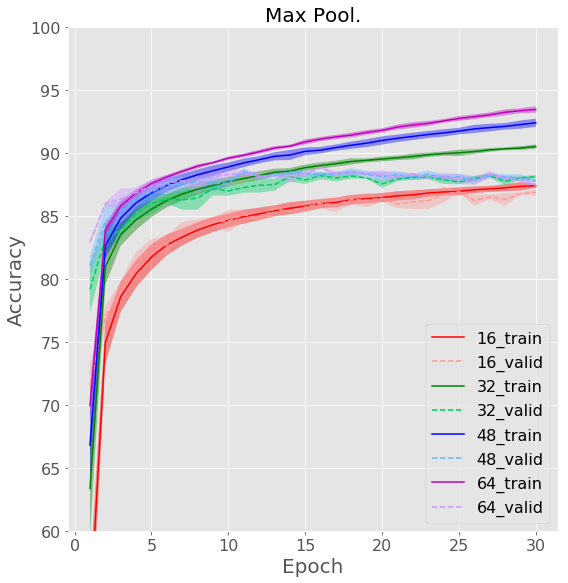

In [34]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']
colors2 = ['#FF9999', '#00CC66', '#66B2FF', '#CC99FF']
downsample = 'max_pooling' 
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Max Pool.', fontsize=20)
plt.savefig('./plots/filters_max.pdf', dpi=400)
# 

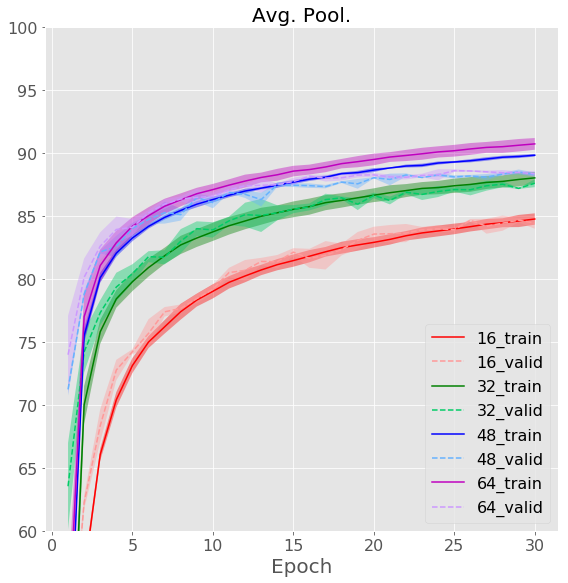

In [36]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']
colors2 = ['#FF9999', '#00CC66', '#66B2FF', '#CC99FF']
downsample = 'avg_pooling' 
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Avg. Pool.', fontsize=20)
plt.savefig('./plots/filters_avg.pdf', dpi=400)
# 

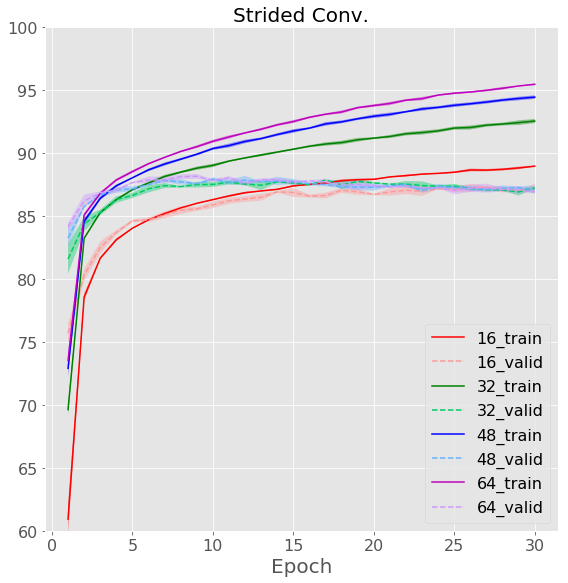

In [35]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']
colors2 = ['#FF9999', '#00CC66', '#66B2FF', '#CC99FF']
downsample = 'strided_convolution' 
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
# plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Strided Conv.', fontsize=20)
plt.savefig('./plots/filters_sc.pdf', dpi=400)
# 

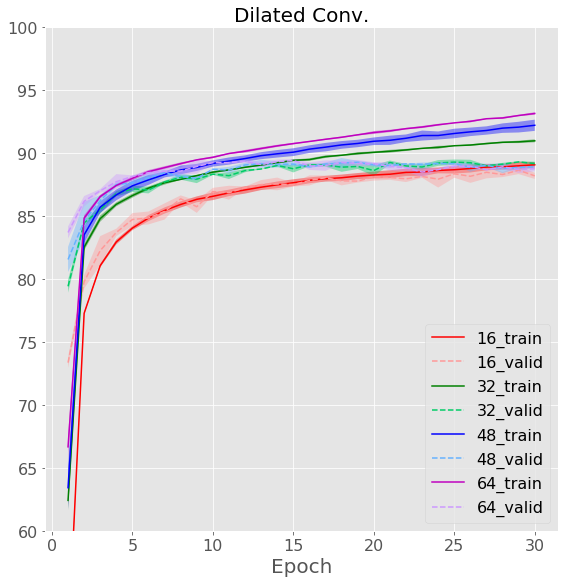

In [37]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']
colors2 = ['#FF9999', '#00CC66', '#66B2FF', '#CC99FF']
downsample = 'dilated_convolution' 
for model_name, c, c2 in zip(model_names,  colors, colors2):
    statistics = stats_means[downsample + model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    train_error = stats_stds[downsample + model_name]['train_acc']
    valid_error = stats_stds[downsample + model_name]['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float'), label=model_name+'_train', c=c)
    plt.fill_between(np.arange(1, len(train_acc)+1), train_acc - train_error, train_acc + train_error, alpha=0.4, facecolor=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float'), label=model_name+'_valid', c=c2, linestyle='--')
    plt.fill_between(np.arange(1, len(valid_acc)+1), valid_acc - valid_error, valid_acc + valid_error, alpha=0.4 ,facecolor=c2)
    
plt.legend(loc=4, fontsize=16)
plt.ylim((60, 100))
# plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.title('Dilated Conv.', fontsize=20)
plt.savefig('./plots/filters_dc.pdf', dpi=400)
# 

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params =[]
for downsample in downsamples:
    for model_name in model_names:
        conv_model = ConvolutionalNetwork(
            input_shape=(batch_size, image_num_channels, image_height, image_width),
            dim_reduction_type=downsample,
            num_output_classes=47, num_filters=int(model_name), num_layers=4, kernel_size=3, use_bias=True)

        model_save_dir = './outputs/run1/num_filters/' + downsample + '/' + model_name + '/saved_models/'
        path = os.path.join(model_save_dir, "{}_{}".format("train_model", 29))

        device = torch.device('cpu')
        state = torch.load(path, map_location=device)
        new_state = rename_dict_key(state['network'])
        conv_model.load_state_dict(state_dict=new_state)
        conv_model.eval()
        models[model_name] = conv_model
        num = count_parameters(conv_model)
        num_params.append(num)

Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 16, 28, 28])
torch.Size([128, 16, 15, 15])
torch.Size([128, 16, 15, 15])
torch.Size([128, 16, 8, 8])
torch.Size([128, 16, 8, 8])
torch.Size([128, 16, 5, 5])
torch.Size([128, 16, 5, 5])
torch.Size([128, 16, 3, 3])
shape before final linear layer torch.Size([128, 16, 2, 2])
Block is built, output volume is torch.Size([128, 47])
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 32, 28, 28])
torch.Size([128, 32, 15, 15])
torch.Size([128, 32, 15, 15])
torch.Size([128, 32, 8, 8])
torch.Size([128, 32, 8, 8])
torch.Size([128, 32, 5, 5])
torch.Size([128, 32, 5, 5])
torch.Size([128, 32, 3, 3])
shape before final linear layer torch.Size([128, 32, 2, 2])
Block is built, output volume is torch.Size([128, 47])
Building basic block of ConvolutionalNetwork using input shape (128, 1, 28, 28)
torch.Size([128, 48, 28, 28])
torch.Size([128, 48, 15, 15])
torch.Size

In [20]:
num_params

[10175,
 34127,
 71903,
 123503,
 10175,
 34127,
 71903,
 123503,
 19455,
 71119,
 155039,
 271215,
 19455,
 71119,
 155039,
 271215]

In [32]:
best_train_accs

['0.8934759122919335',
 '0.9165332906530089',
 '0.8934659090909091',
 '0.9119318181818182']

In [34]:
best_valid_accs

[0.8857977642276422, 0.8861153455284553, 0.8895452235772358, 0.889354674796748]

In [12]:
x, y = val_data.next()
x_test, y_test = torch.Tensor(x).float().to(device='cpu'), torch.Tensor(y).long().to(device='cpu')  # send data to device as torch tensors

In [13]:
def hook(module, inputdata, output):
    outputs.append(output)
    
feature_maps = OrderedDict()

for model_name in model_names:
    conv_model = models[model_name]
    outputs = []
    for layer_name in conv_model.layer_dict.keys():
        print(model_name + '_' + layer_name)
        h = conv_model.layer_dict[layer_name].register_forward_hook(hook)
        h_x = conv_model(x_test)
        h.remove()
        feature_maps[model_name + '_' + layer_name] = outputs[-1].detach().numpy()
    print(len(outputs))

32_filters_conv_0
32_filters_dim_reduction_max_pool_0
32_filters_conv_1
32_filters_dim_reduction_max_pool_1
32_filters_conv_2
32_filters_dim_reduction_max_pool_2
32_filters_conv_3
32_filters_dim_reduction_max_pool_3
8
64_filters_conv_0
64_filters_dim_reduction_max_pool_0
64_filters_conv_1
64_filters_dim_reduction_max_pool_1
64_filters_conv_2
64_filters_dim_reduction_max_pool_2
64_filters_conv_3
64_filters_dim_reduction_max_pool_3
8
128_filters_conv_0
128_filters_dim_reduction_max_pool_0
128_filters_conv_1
128_filters_dim_reduction_max_pool_1
128_filters_conv_2
128_filters_dim_reduction_max_pool_2
128_filters_conv_3
128_filters_dim_reduction_max_pool_3
8
256_filters_conv_0
256_filters_dim_reduction_max_pool_0
256_filters_conv_1
256_filters_dim_reduction_max_pool_1
256_filters_conv_2
256_filters_dim_reduction_max_pool_2
256_filters_conv_3
256_filters_dim_reduction_max_pool_3
8


In [17]:
def show_batch_feature_maps(outputs):
    grid_size = int(np.ceil((outputs.shape[0] ** 0.5)))
    fig, ax = plt.subplots(grid_size, grid_size)
    ax = ax.flatten()
    
    for i in range(outputs.shape[0]):
        ax[i].imshow(outputs[i], cmap='Greys')
        ax[i].axis('off')
    plt.show()
    
    return fig, ax

32_filters_conv_0


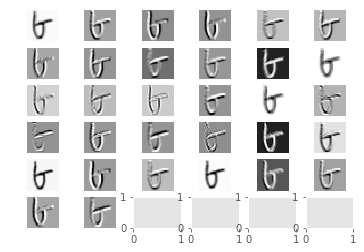

32_filters_dim_reduction_max_pool_0


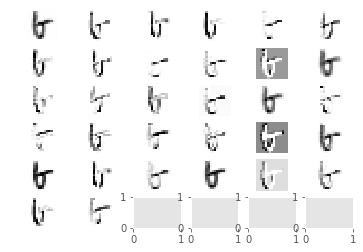

32_filters_conv_1


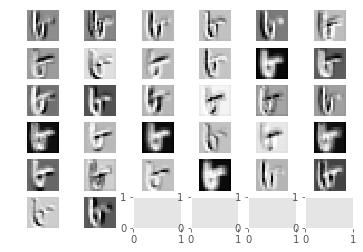

32_filters_dim_reduction_max_pool_1


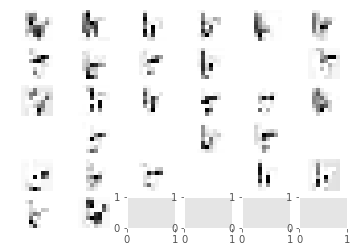

32_filters_conv_2


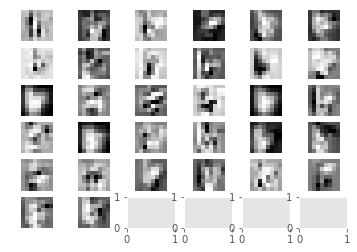

32_filters_dim_reduction_max_pool_2


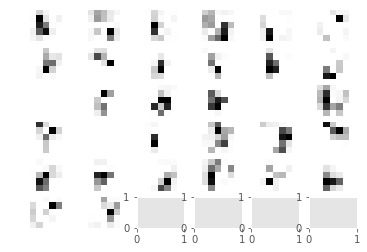

32_filters_conv_3


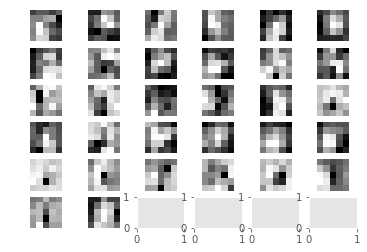

32_filters_dim_reduction_max_pool_3


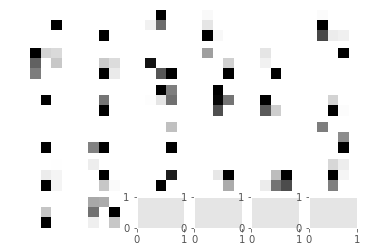

64_filters_conv_0


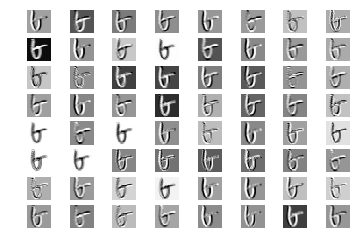

64_filters_dim_reduction_max_pool_0


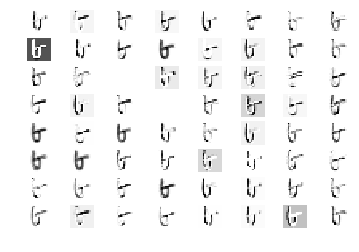

64_filters_conv_1


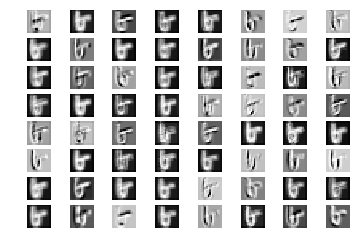

64_filters_dim_reduction_max_pool_1


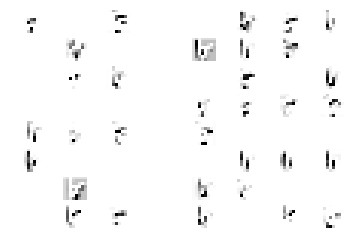

64_filters_conv_2


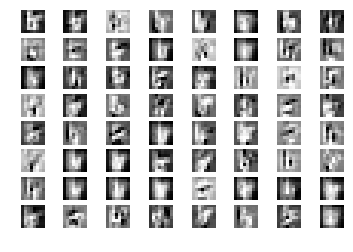

64_filters_dim_reduction_max_pool_2


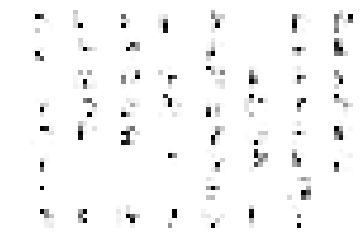

64_filters_conv_3


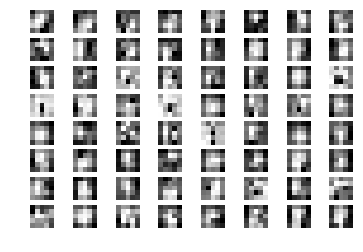

64_filters_dim_reduction_max_pool_3


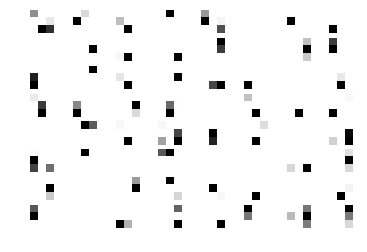

128_filters_conv_0


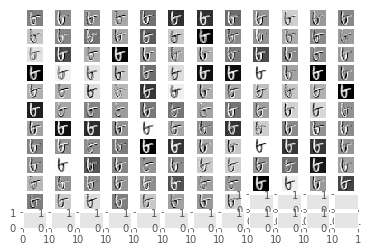

128_filters_dim_reduction_max_pool_0


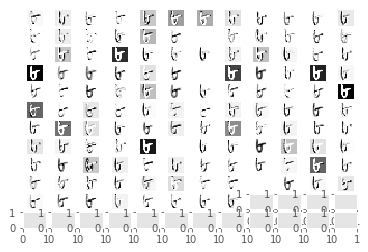

128_filters_conv_1


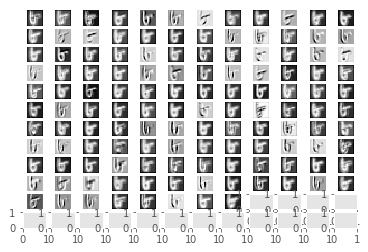

128_filters_dim_reduction_max_pool_1


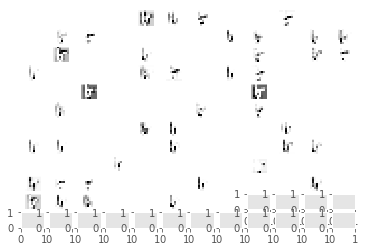

128_filters_conv_2


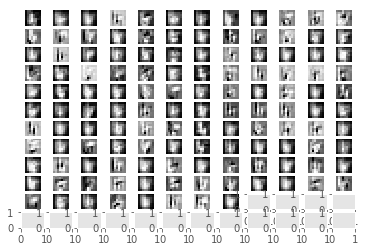

128_filters_dim_reduction_max_pool_2


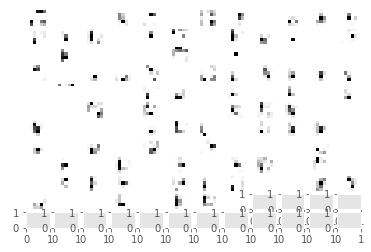

128_filters_conv_3


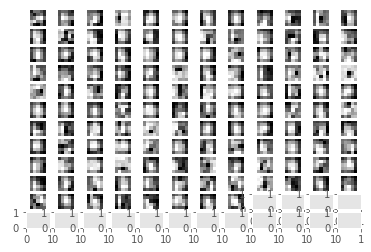

128_filters_dim_reduction_max_pool_3


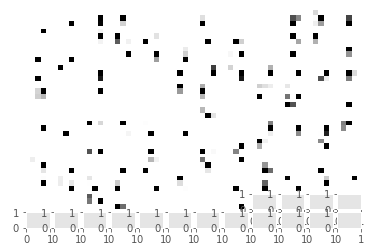

256_filters_conv_0


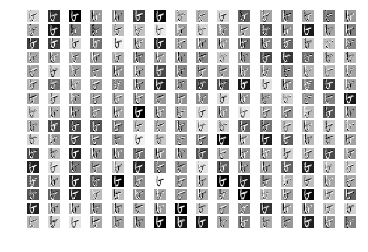

256_filters_dim_reduction_max_pool_0


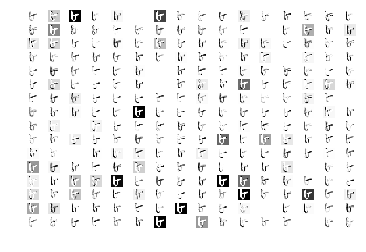

256_filters_conv_1


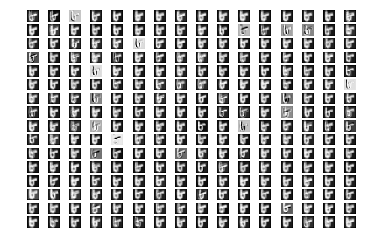

256_filters_dim_reduction_max_pool_1


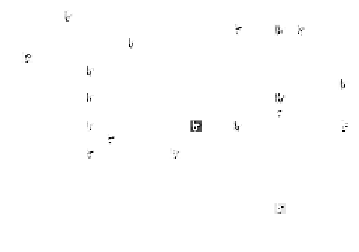

256_filters_conv_2


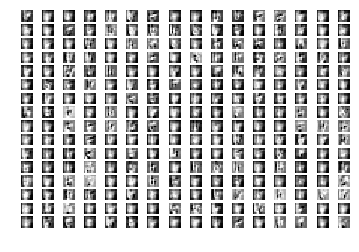

256_filters_dim_reduction_max_pool_2


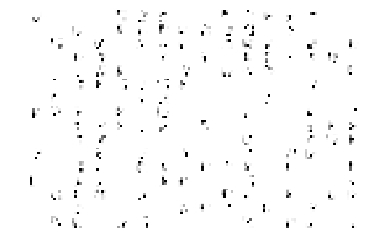

256_filters_conv_3


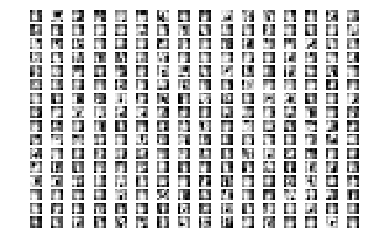

256_filters_dim_reduction_max_pool_3


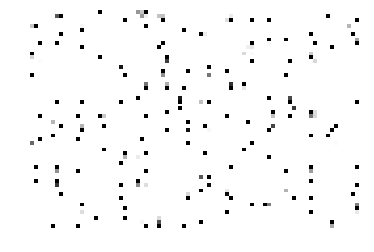

In [18]:
for model_name in model_names:
    conv_model = models[model_name]
    for layer_name in conv_model.layer_dict.keys():
        print(model_name + '_' + layer_name)
        outputs = feature_maps[model_name + '_' + layer_name][0]
        show_batch_feature_maps(outputs)